In [83]:
import json
import os
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
assert os.cpu_count() == 96

In [85]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [86]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
PLOT_STATES: bool = False

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [87]:
# TPU + high dim
# if not PAPERMILL:
#     JAX_PLATFORM = JaxPlatform.TPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 32
#     TOTAL_SAMPLES = N_TEMPS * 4
#     LOOP_N_TEMPS_Y = True
#     N_SAMPLES_VECTORISE = 1

# DIMENSIONS = 4
# SIZE = 32

# TEMP_MIN = 6.0 / 2
# TEMP_MAX = 6.8 / 2

# THERMALISE_STEPS: int = 100
# THERMALISE_SWEEPS_PER_STEP: int = 100

In [88]:
# # CPU + Quick
# if not PAPERMILL:
#     JAX_PLATFORM = JaxPlatform.CPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 96 * 2
#     TOTAL_SAMPLES = 96 * 2 * 2 * 2
#     LOOP_N_TEMPS_Y = False
#     N_SAMPLES_VECTORISE = 2

#     DIMENSIONS = 2
#     SIZE = 32

#     # TEMP_MIN = 6.0 / 2
#     # TEMP_MAX = 6.8 / 2

#     THERMALISE_STEPS: int = 25
#     THERMALISE_SWEEPS_PER_STEP: int = 100

In [89]:
# if not PAPERMILL:
#     ...
#     JAX_PLATFORM = JaxPlatform.TPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 32
#     TOTAL_SAMPLES: int = 128
#     N_SAMPLES_VECTORISE = 1

#     DIMENSIONS = 3

#     # TEMP_MIN = 2.1
#     # TEMP_MAX = 2.7
#     SIZE = 64
#     TOTAL_SAMPLES = N_TEMPS
# TEMP_MIN = 6.0
# TEMP_MAX = 6.8

In [90]:
#! Papermill-like
if not PAPERMILL:
    # PAPERMILL = True
    RNG_SEED = 1
    JAX_PLATFORM = JaxPlatform.TPU
    ALGORITHM = AlgorithmChoice.WOLFF
    DIMENSIONS = 2
    SPIN = 0.5
    TOTAL_SAMPLES = 96 * 4
    N_TEMPS = 96
    N_SAMPLES_VECTORISE = 4
    THERMALISE_STEPS = 100
    # THERMALISE_SWEEPS_PER_STEP = 250
    DO_AUTOCORRELATION = True
    TEMP_MIN = 0.75
    TEMP_MAX = 5.0
    SIZE = 64

In [91]:
Path().resolve()

PosixPath('/home/jeppe/JaxIsingModel')

In [92]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "PLOT_STATES",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Cache already previously initialized at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/JaxIsingModel/experiments/last')


In [93]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    raise ValueError(f"Should have at least {DEVICE_COUNT} temperatures")
N_TEMPS_X = DEVICE_COUNT
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

BETA_MIN = 1.0 / c.temp_max
BETA_MAX = 1.0 / c.temp_min
betas = np.geomspace(BETA_MIN, BETA_MAX, c.n_temps)

match c.algorithm:
    case AlgorithmChoice.WOLFF:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 96
c.n_temps=96
N_TEMPS_X=8
N_TEMPS_Y=12
N_SAMPLES_PER_TEMP=4
--c.n_samples_vectorise=4
--N_SAMPLES_LOOP=1
Vectorised count: 384
Total sweeps: 1_920_000


In [94]:
# Single state
model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
state = State.new_uniform_random(
    rng_key=k.new,
    dimensions=c.dimensions,
    size=c.size,
    beta=1.0,
    model=model,
    algorithm=algorithm,
    id_=0,
)

initial_state = state

state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
measured = state.measure()

state.calculate_energy()
state.calculate_magnetisation_density()

Array(-0.00268555, dtype=float32)

# Thermalisation

In [95]:
@transforms(in_axes=(0, None, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    spin: float,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model_kwargs: dict[str, Any],
    algorithm: Algorithm,
    num_prints: int = 10,
):
    # Make state
    model = IsingModel.new(
        spin=spin,
        **model_kwargs,
    )

    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)


# rng_key: RNGKey
# spin: float
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 5

thermalise_timer = Stopwatch.start()
# print(
#         state_keys,
#     c.spin,
#     c.dimensions,
#     c.size,
#     _betas,
#     ids,
#     c.thermalise_steps,
#     c.thermalise_sweeps_per_step,
#     MODEL_BASE_PARAMS,
#     c.algorithm,
#     thermalise_num_prints,
# )
states, evolve_measurements = make_and_thermalise_states(
    state_keys,
    c.spin,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    MODEL_BASE_PARAMS,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_time = thermalise_timer.time()
to_save["thermalise_time"] = thermalise_time
print(f"Ran thermalisation program in: {thermalise_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 12, 4)


/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|          | 0/800 [00:00<?, ?it/s]

Ran thermalisation program in: 59.21163606643677 sec.


In [96]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [97]:
# Fit saturating decay times to quantifiably understand whether we have fully thermalised
def fit_thermalisation(group):
    x = group["sweeps"]
    y = group["energy"]

    amplitude = np.max(y) - np.min(y)
    decay = np.max(x)
    offset = y.iloc[-1]

    params = SaturatingExponential.make_params()
    params["amplitude"].set(amplitude)
    params["decay"].set(decay, min=0, max=np.inf)
    params["c"].set(offset)

    fit = SaturatingExponential.fit(y, params, x=x)

    assert np.ptp(group["temp"]) == 0.0

    return pd.Series(
        {
            "temp": group["temp"].iloc[0],
            "therm_amplitude": fit.params["amplitude"].value,
            "therm_amplitude_sd": fit.params["amplitude"].stderr,
            "therm_decay": fit.params["decay"].value,
            "therm_decay_sd": fit.params["decay"].stderr,
            "therm_offset": fit.params["c"].value,
            "therm_offset_sd": fit.params["c"].stderr,
        }
    )


evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
    fit_thermalisation
)


def _has_thermalised():
    high_temp_df = evolve_meas_fit_df[
        evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
    ]
    therm_check_df = high_temp_df[
        high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
    ]

    # We have no data to check probably because system is very very thermalised
    # and thus has no data to fit to exponential
    if not len(therm_check_df):
        return True

    longest_decay = therm_check_df["therm_decay"].max()
    print(longest_decay)
    if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
        return True

    return False


has_thermalised = _has_thermalised()
has_thermalised

649.5959656736843


True

In [98]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

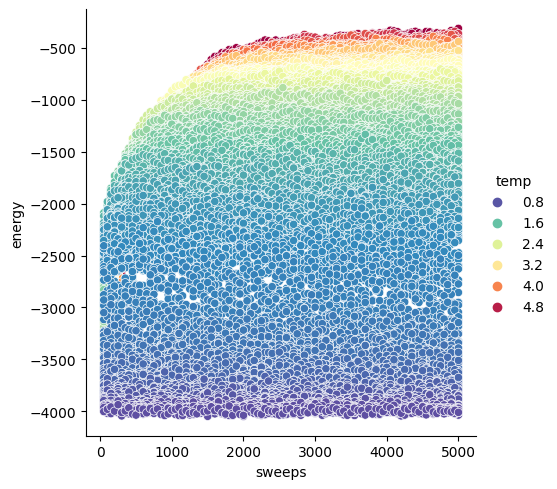

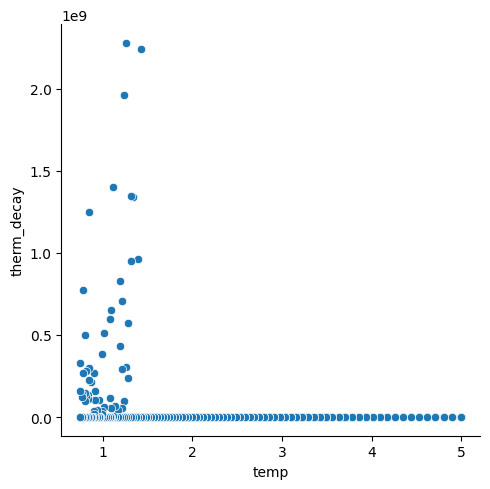

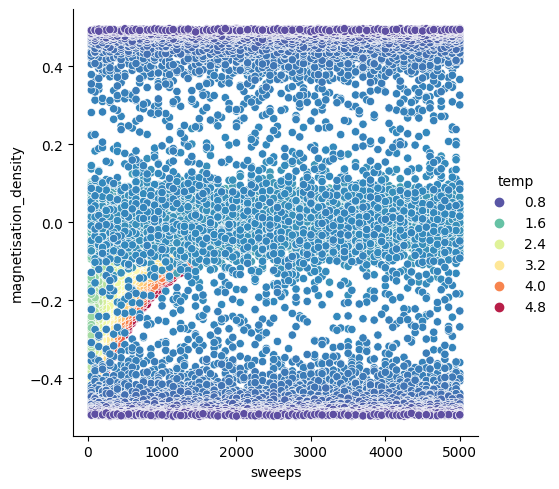

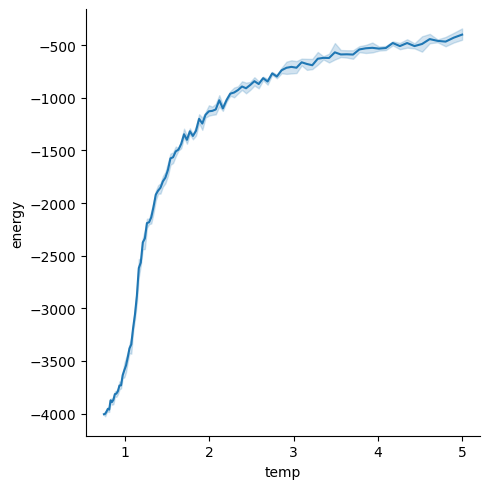

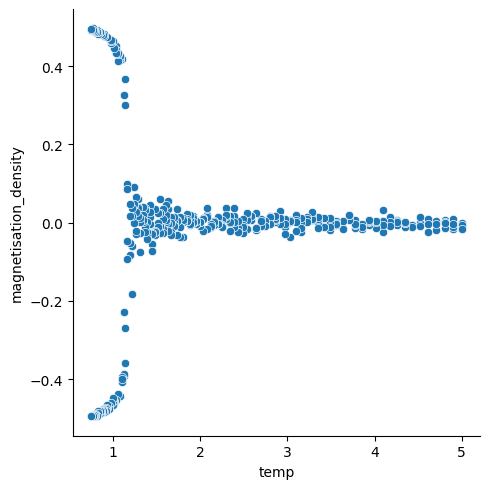

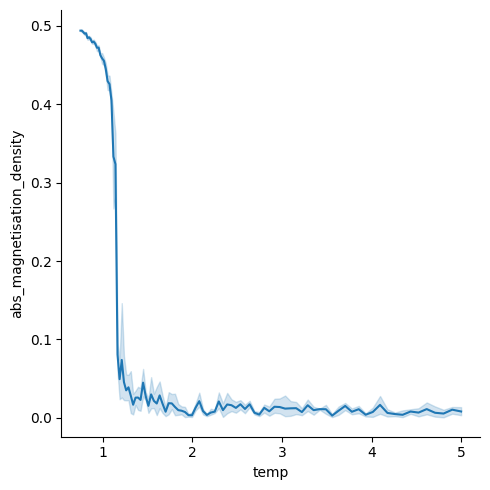

In [99]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_therm_fit = sns.relplot(
    data=evolve_meas_fit_df,
    x="temp",
    y="therm_decay",
)
fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [100]:
if c.plot_states or True:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [101]:
if c.plot_states or True:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

interactive(children=(IntSlider(value=47, description='i', max=95), Output()), _dom_classes=('widget-interact'…

In [102]:
if not has_thermalised:
    raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [103]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function get_autocorrelation includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|          | 0/8000 [00:00<?, ?it/s]

Ran autocorrelation program in: 64.26181554794312 sec.


In [105]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.beta,state.model.spin_states,state.model.interaction_bilinear,state.model.interaction_biquadratic,state.model.interaction_anisotropy,state.model.interaction_bicubic,state.model.interaction_external_field,state.model.nuclear_magnetic_moment,state.algorithm.probabilistic_cluster_accept,state.id_,state.steps,state.sweeps,temp
0,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.99648607, 0.9926228, 0.9891012, 0.9856...","[1.0, 0.9886144, 0.97857094, 0.96962804, 0.960...",501.224670,186.550125,0.200000,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,0,11533,7000,5.000000
1,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[0.99999994, 0.9874065, 0.97516066, 0.9637206,...","[0.99999994, 0.99003696, 0.9802731, 0.9702004,...",163.246017,204.343750,0.200000,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,1,11618,7000,5.000000
2,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.9970788, 0.9941138, 0.9911152, 0.98805...","[1.0, 0.99210423, 0.9847691, 0.97688144, 0.968...",620.334595,267.663147,0.200000,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,2,11572,7000,5.000000
3,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.98558575, 0.9719345, 0.9590681, 0.9454...","[1.0, 0.9928622, 0.9857711, 0.9793564, 0.97287...",114.874710,284.394775,0.200000,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,3,11580,7000,5.000000
4,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.9951785, 0.99039906, 0.9858679, 0.9813...","[1.0000001, 0.9763864, 0.9541781, 0.9341758, 0...",418.252289,93.797531,0.204034,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,4,11473,7000,4.901142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.019964376, -0.006319065, -0.010079659,...","[1.0, 0.013963278, 0.0025972668, -0.018409826,...",2.000000,2.000000,1.306971,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,379,27817224,7000,0.765128
380,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, -0.012910748, 0.015759733, -0.017132675,...","[1.0, 0.012595843, 0.017968422, -0.0026676701,...",2.000000,2.000000,1.333333,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,380,27937749,7000,0.750000
381,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[0.99999994, -0.06470123, 0.018097546, -0.0396...","[1.0, -0.084423795, 0.015581962, -0.028363882,...",2.000000,2.000000,1.333333,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,381,27920089,7000,0.750000
382,1000,2,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[1.0, 0.02315801, 0.022654356, 0.010496456, -0...","[1.0, 0.00781441, 0.021374958, -0.0034458851, ...",2.000000,2.000000,1.333333,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,382,27932885,7000,0.750000


,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.beta,state.model.spin_states,state.model.interaction_bilinear,...,state.model.interaction_bicubic,state.model.interaction_external_field,state.model.nuclear_magnetic_moment,state.algorithm.probabilistic_cluster_accept,state.id_,state.steps,state.sweeps,temp,energy_fit,mag_dens_fit
0,1000,2,0,1.000000,1.000000,501.22467,186.550125,0.200000,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,11533,7000,5.00,1.000000e+00,1.000000e+00
0,1000,2,2,0.996486,0.988614,501.22467,186.550125,0.200000,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,11533,7000,5.00,9.960177e-01,9.893363e-01
0,1000,2,4,0.992623,0.978571,501.22467,186.550125,0.200000,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,11533,7000,5.00,9.920513e-01,9.787863e-01
0,1000,2,6,0.989101,0.969628,501.22467,186.550125,0.200000,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,11533,7000,5.00,9.881007e-01,9.683488e-01
0,1000,2,8,0.985629,0.960001,501.22467,186.550125,0.200000,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,11533,7000,5.00,9.841658e-01,9.580226e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,1000,2,52,0.047013,0.051086,2.00000,2.000000,1.333333,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,383,27870120,7000,0.75,5.109089e-12,5.109089e-12
383,1000,2,54,-0.059063,-0.057358,2.00000,2.000000,1.333333,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,383,27870120,7000,0.75,1.879529e-12,1.879529e-12
383,1000,2,56,0.008923,0.026610,2.00000,2.000000,1.333333,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,383,27870120,7000,0.75,6.914400e-13,6.914400e-13
383,1000,2,58,-0.007584,0.006898,2.00000,2.000000,1.333333,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,383,27870120,7000,0.75,2.543666e-13,2.543666e-13


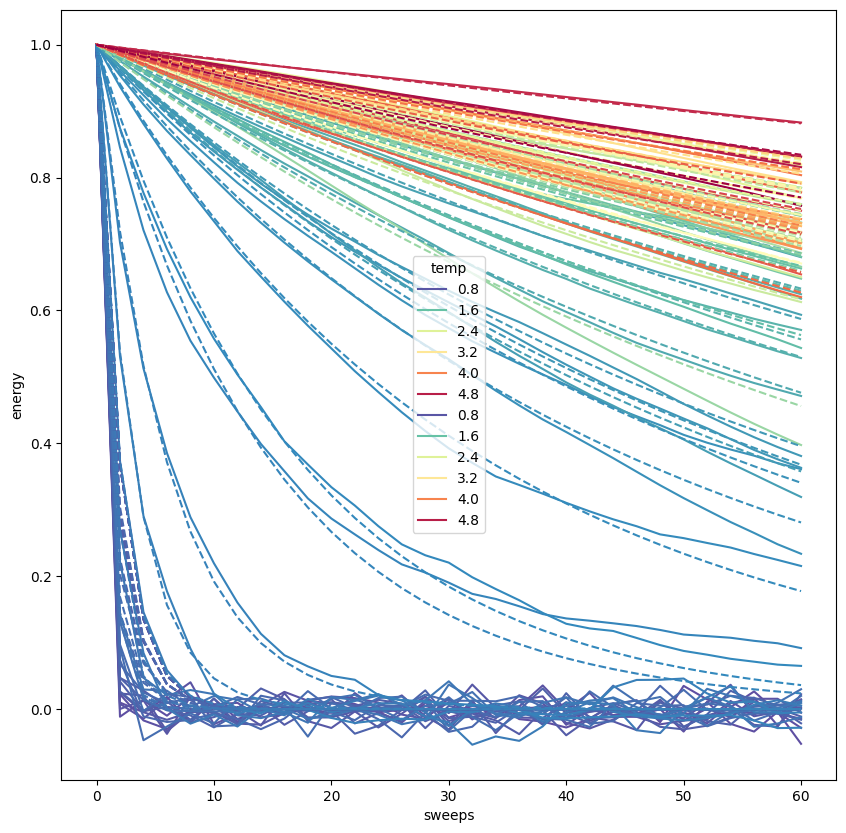

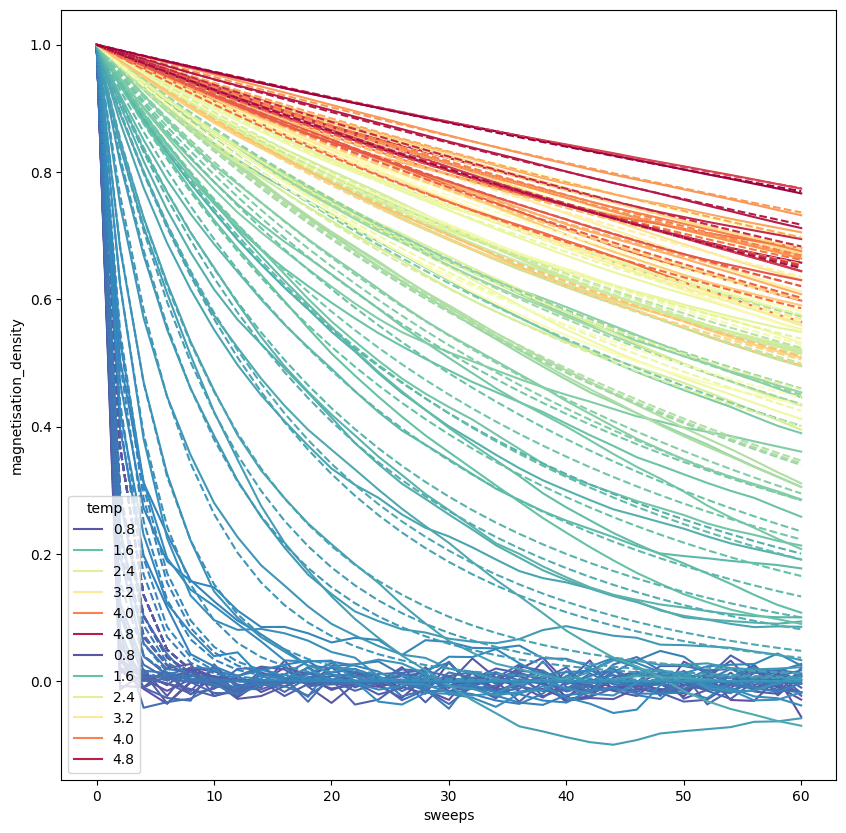

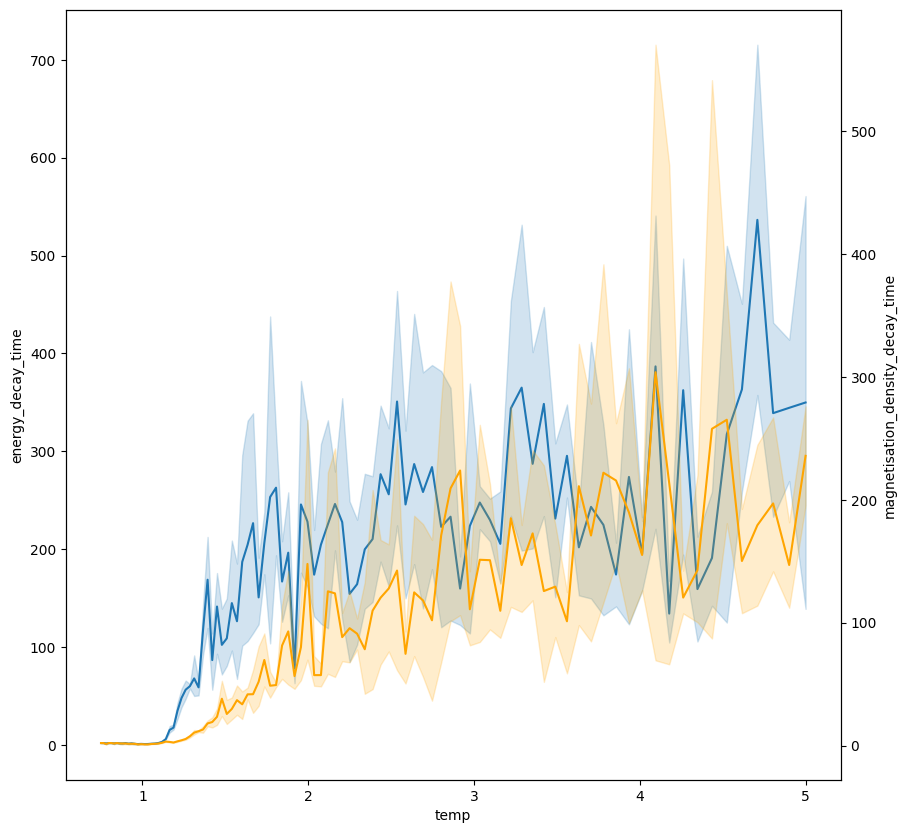

In [106]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [108]:
@transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
def measure_equilibrium(
    key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
) -> Measurement:
    def body_fun(carry: State, x: RNGKey):
        _rng_key = x
        measurements = carry.evolve_and_measure_multiple(
            rng_key=_rng_key, num=num, sweeps=sweeps
        )

        return carry, measurements

    keys = random.split(key=key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=body_fun, init=state, xs=keys)

    return measurements


keys = k.shaped(states.transformation_shape)

measurement_timer = Stopwatch.start()
equil_measurements = measure_equilibrium(
    keys,
    states,
    c.measure_equilibrium_steps,
    c.measure_equilibrium_num,
    c.measure_equilibrium_sweeps_per_step,
    5,
)
equil_measurements.block_until_ready()

measurement_time = measurement_timer.time()
to_save["measurement_time"] = measurement_time
print(f"Ran measurement program in: {measurement_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|          | 0/800 [00:00<?, ?it/s]

Ran measurement program in: 71.57334876060486 sec.


In [110]:
_eq_df = equil_measurements.to_df()
eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
eq_df

,state_id,beta,steps,sweeps,energy,magnetisation_density
0,0,0.200000,8393,5005,-420.0,-0.000732
0,0,0.200000,8394,5005,-414.0,-0.003418
0,0,0.200000,8394,5005,-416.0,-0.001953
0,0,0.200000,8396,5005,-422.0,-0.000488
0,0,0.200000,8392,5005,-420.0,-0.001953
...,...,...,...,...,...,...
38399,383,1.333333,19929749,5005,-3976.0,-0.491943
38399,383,1.333333,19929767,5005,-4000.0,-0.493896
38399,383,1.333333,19929782,5005,-3924.0,-0.488770
38399,383,1.333333,19925686,5005,-3978.0,0.492188


In [111]:
# Create two dataframes of different 'shapes'
# meas_df: holds data that is defined on every state
# sample_df: holds data that is summarised across particular systems (those with same state_id)
# temp_df: holds data that is summarised across all systems of a particular temperature

meas_df = eq_df.copy()
meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

temp_df = pd.DataFrame()

# Energy - Summarised
temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
temp_df["energies_mean"] = temp_group["energy"].mean()
temp_df["energies_var"] = temp_group["energy"].var()

# Magnetisation Density - Summarised
temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()

# index
temp_df = temp_df.reset_index()

# Heat Capacity
temp_df["heat_cap_gradient"] = np.abs(
    np.gradient(temp_df["energies_mean"], temp_df["natural_temperature"])
)
temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
    constants.Boltzmann * np.square(temp_df["natural_temperature"])
)

# Magnetic Susceptibility
if not c.interaction_external_field:
    temp_df["mag_sus_gradient"] = states.size * np.abs(
        np.gradient(temp_df["mag_dens_mean"], temp_df["natural_temperature"])
    )
    temp_df["mag_sus_fluctuation"] = states.size * temp_df["beta"] * temp_df["mag_dens_var"]

# Binder cumulant
sample_df = pd.DataFrame()

meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

sample_group = meas_df.groupby("state_id")

sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(sample_df["mag_1_mean"])
sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
    3.0 * np.square(sample_df["mag_2_mean"])
)

sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
sample_df["temperature"] = sample_group["temperature"].first()
sample_df["beta"] = sample_group["beta"].first()

meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")


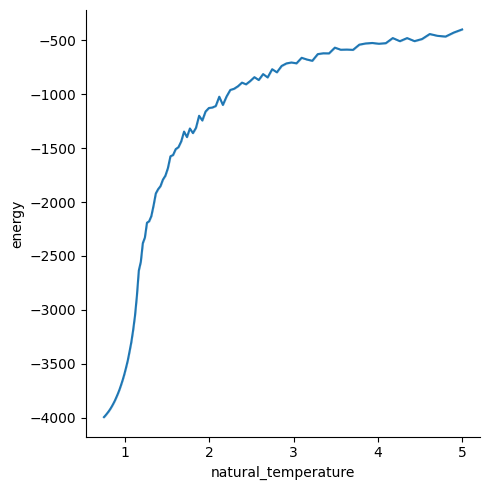

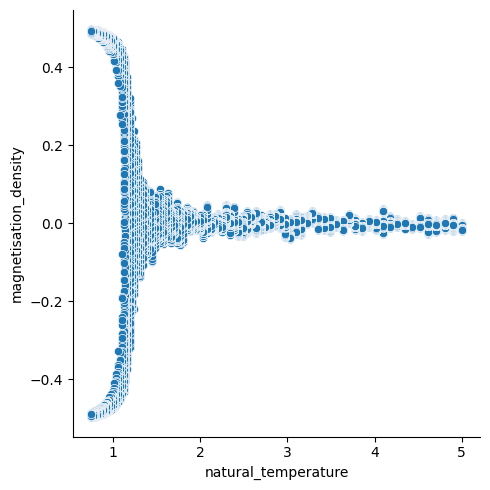

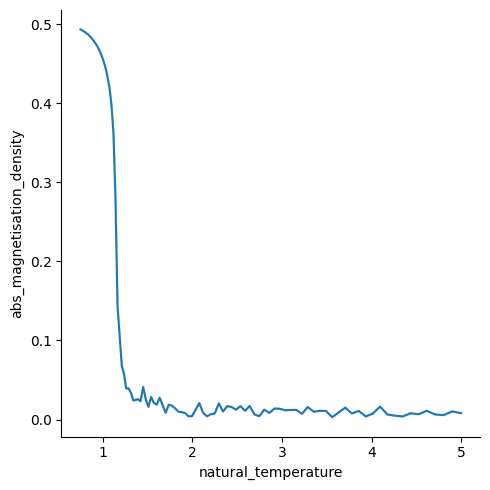

In [112]:
fig_measure_energy_temp = sns.relplot(
    data=meas_df,
    x="natural_temperature",
    y="energy",
    kind="line",
)
fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

fig_measure_mag_dens_temp = sns.relplot(
    data=meas_df,
    x="natural_temperature",
    y="magnetisation_density",
    # kind="line",
)
fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

fig_measure_abs_mag_dens_temp = sns.relplot(
    data=meas_df,
    x="natural_temperature",
    y="abs_magnetisation_density",
    kind="line",
)
fig_measure_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_abs_mag_dens_temp.png")

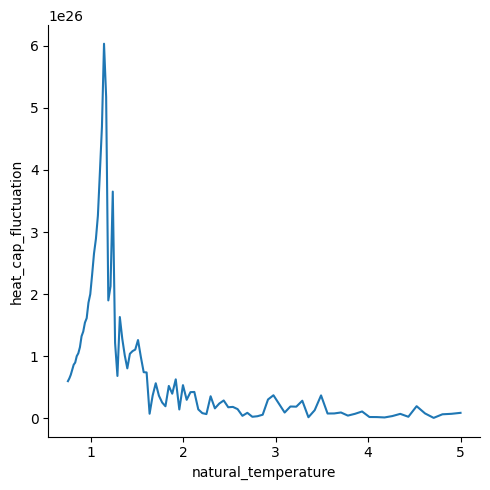

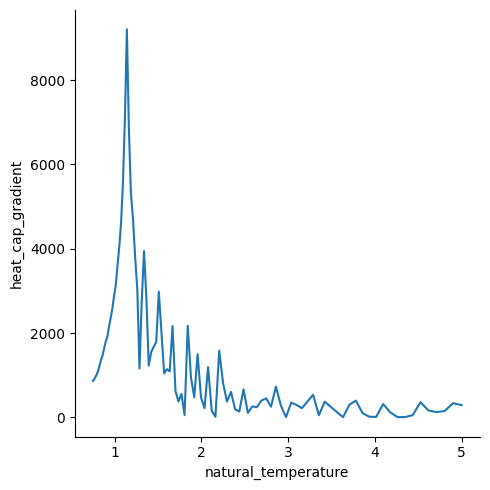

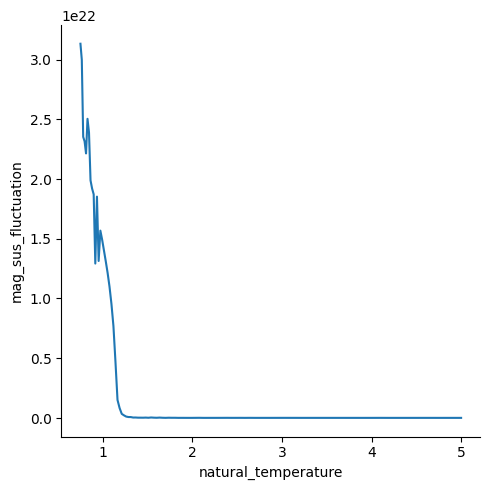

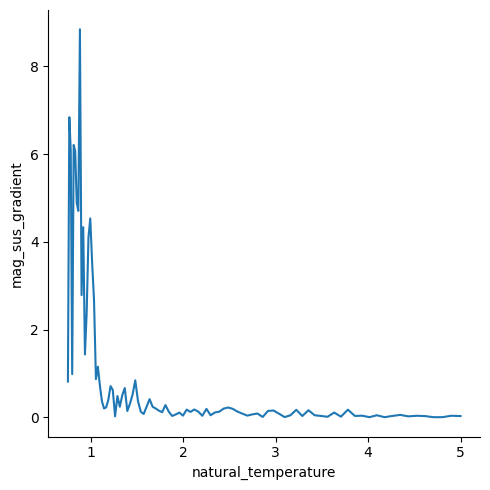

In [113]:
fig_measure_heat_cap_fluctuation_temp = sns.relplot(
    data=temp_df,
    x="natural_temperature",
    y="heat_cap_fluctuation",
    kind="line",
)
fig_measure_heat_cap_fluctuation_temp.savefig(
    SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
)

fig_measure_heat_cap_gradient_temp = sns.relplot(
    data=temp_df,
    x="natural_temperature",
    y="heat_cap_gradient",
    kind="line",
)
fig_measure_heat_cap_gradient_temp.savefig(
    SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
)

if not c.interaction_external_field:
    fig_measure_mag_sus_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="mag_sus_fluctuation",
        kind="line",
    )
    fig_measure_mag_sus_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
    )

    fig_measure_mag_sus_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="mag_sus_gradient",
        kind="line",
    )
    fig_measure_mag_sus_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
    )

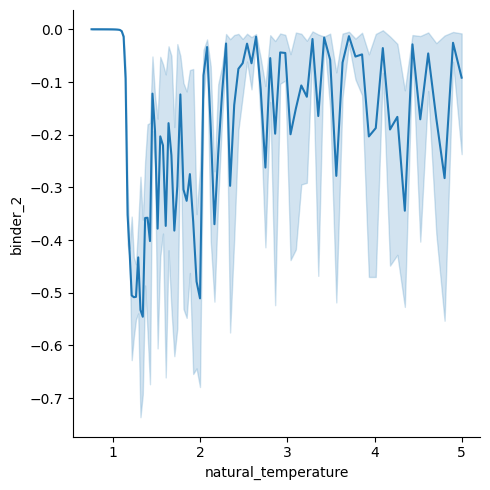

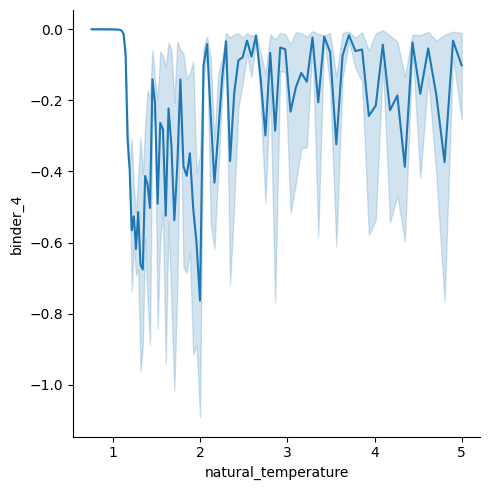

In [114]:
fig_measure_binder_2 = sns.relplot(
    data=sample_df,
    x="natural_temperature",
    y="binder_2",
    kind="line",
)
fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

fig_measure_binder_4 = sns.relplot(
    data=sample_df,
    x="natural_temperature",
    y="binder_4",
    kind="line",
)
fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [115]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )